<a href="https://colab.research.google.com/github/Seenuprime/Deep-Learning/blob/main/09_Milestone_Project_Skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 2: SkimLit

In this notebook we are going to build and NLP model to make reading medical abstract easier.

source: https://arxiv.org/abs/1710.06071

##Getting the Data

We can find the source [here](https://github.com/Franck-Dernoncourt/pubmed-rct).

In [182]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
pubmed-rct  sample_data


In [183]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [184]:
## Cheking what files are there in the PubMed_20k_RCT Dateset
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [185]:
with open('pubmed-rct/PubMed_20k_RCT/test.txt', 'r') as test_file:
  data = test_file.readlines()

len(data), len(data[0])

(35135, 12)

In [186]:
data[0]

'###24845963\n'

In [187]:
data[1]

'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n'

In [188]:
## Going to start our experiments with PubMed_20k_RCT with number replaced with '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [189]:
## Getting the file directories
import os
file_names = [os.path.join(data_dir,dir) for dir in os.listdir(data_dir)]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Prepocess the Data

Write a function read in all the lines of target text file.

In [190]:
def read_lines(file_path):
  """
  Takes filepath and reads the .txt file line-by-line and returns the data in the form of list
  """
  with open(file_path, 'r') as file:
    return file.readlines()

In [191]:
train_data = read_lines(file_names[1])
train_data[: 20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [192]:
len(train_data)

35135

Make train_data into this format:

```
[{'line_number': 0,
  'target': 'Backgound',
  'text': 'the data',
  'total_lines': 10
}]
```

In [193]:
def data_dict(data_list):
  """
  This function takes list of text data and converts it into list of dictionary containing
  {'line_number': number of the line,
  'target': the category,
  'text': the actual content,
  'total_lines': total number of lines in each senction}

  The section is divided by eliminating the line containing '###' and the len(line) != 1.
  """
  data_dict = []
  for i, line in enumerate(data_list):
    if "###" not in line and len(line) != 1:
      split = line.split('\t')
      data_dict.append({'line_number': i,
                              'target': split[0],
                              'text': split[1],
                              'total_lines': len(data_list[i-1])})

  return data_dict

In [194]:
train_data_dict = data_dict(train_data)
train_data_dict[: 15]

[{'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
  'total_lines': 12},
 {'line_number': 2,
  'target': 'RESULTS',
  'text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
  'total_lines': 152},
 {'line_number': 3,
  'target': 'RESULTS',
  'text': 'Liver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
  'total_lines': 181},
 {'line_number': 4,
  'target': 'RESULTS',
  'text': 'Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @

In [195]:
def data_dict(data_list):
  abstract_lines = ''
  abstract_samples = []

  for line in data_list:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ''

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['line_number'] = abstract_line_number
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [196]:
train_data_dict = data_dict(train_data)
train_data_dict[:5]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'total_lines': 8},
 {'line_number': 1,
  'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'total_lines': 8},
 {'line_number': 2,
  'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'total_lines': 8},
 {'line_number': 3,
  'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspart

In [197]:
test_data = read_lines(file_names[2])
test_data_dict = data_dict(test_data)
test_data_dict[:5]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'total_lines': 9},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'total_lines': 9},
 {'line_number': 2,
  'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'total_lines': 9},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'total_lines': 9},
 {'line_

In [198]:
val_data = read_lines(file_names[0])
val_data_dict = data_dict(val_data)
val_data_dict[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data in the form of dictionary, let's add them into a DataFrame

In [199]:
import pandas as pd

train_data_df = pd.DataFrame(train_data_dict)
train_data_df.head(15)

,line_number,target,text,total_lines
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8
1,1,RESULTS,a post hoc analysis was conducted with the use...,8
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8
3,3,RESULTS,survival analyses were used to assess the asso...,8
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8
5,5,RESULTS,when mean hemodynamic profiles were compared i...,8
6,6,RESULTS,multivariable analyses revealed that patients ...,8
7,7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,8
8,8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8
9,0,BACKGROUND,minimally invasive endovascular aneurysm repai...,12


In [200]:
## Distribution of labels
train_data_df.target.value_counts()

target
METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

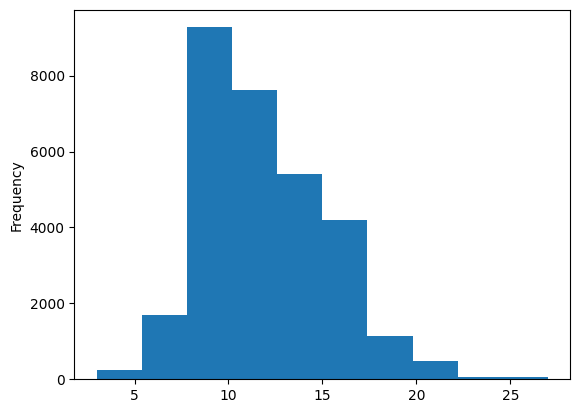

In [201]:
## Check the length of differect line
train_data_df.total_lines.plot(kind='hist')

In [202]:
test_data_df = pd.DataFrame(test_data_dict)
test_data_df.head(15)

,line_number,target,text,total_lines
0,0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,9
1,1,BACKGROUND,it is not clear whether these patients would b...,9
2,2,OBJECTIVE,we sought to determine whether a @-month cours...,9
3,3,METHODS,asthmatic patients who were ige sensitized to ...,9
4,4,METHODS,primary outcomes were improvement in quality o...,9
5,5,RESULTS,sixty-five patients were randomized .,9
6,6,RESULTS,fifty-nine patients started treatment ( @ rece...,9
7,7,RESULTS,fifty-six patients took the full @ months of m...,9
8,8,RESULTS,"between the voriconazole and placebo groups , ...",9
9,9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9


In [203]:
val_data_df = pd.DataFrame(val_data_dict)
val_data_df.head(15)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


## Getting the lists of sentences

In [204]:
train_sentences = train_data_df.text.tolist()
test_sentences = test_data_df.text.tolist()
val_sentences = val_data_df.text.tolist()

In [205]:
len(train_sentences), len(test_sentences), len(val_sentences)

(30135, 30212, 180040)

In [206]:
# First 6 sentences in trian_sentence
train_sentences[: 6]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .",
 'when mean hemodynamic profiles were compared in patients with abnormal versus 

##Make Numeric labels (OneHot Encoding)

### Turning into categories

In [207]:
# train_data_df.target.unique()

In [208]:
# import numpy as np
# mapping = {
#         'OBJECTIVE': 0,
#         'METHODS': 1,
#         'RESULTS': 2,
#         'CONCLUSIONS': 3,
#         'BACKGROUND': 4
# }
# train_data_df['labels'] = np.where(train_data_df.target.isin(mapping), train_data_df.target.map(mapping), 5)

In [209]:
# train_data_df.target.unique(), train_data_df.labels.unique()

In [210]:
# train_data_df['target'].value_counts(), train_data_df.labels.value_counts()

### Label Encoding (other way)

In [211]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data_df.target)
test_labels_encoded = label_encoder.transform(test_data_df.target)
val_labels_encoded = label_encoder.transform(val_data_df.target)

In [212]:
test_labels_encoded[:5], test_data_df.target[:5]

(array([0, 0, 3, 2, 2]),
 0    BACKGROUND
 1    BACKGROUND
 2     OBJECTIVE
 3       METHODS
 4       METHODS
 Name: target, dtype: object)

In [213]:
## Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### OneHot Encoder

In [214]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) ## We need non sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_data_df['target'].to_numpy().reshape(-1, 1))
train_data_df.target[:5], train_labels_one_hot[: 5]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(0    BACKGROUND
 1       RESULTS
 2       RESULTS
 3       RESULTS
 4       RESULTS
 Name: target, dtype: object,
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]))

In [215]:
## OneHot Encoding Testing labels
test_labels_one_hot = one_hot_encoder.transform(test_data_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [216]:
## OneHot Encoding validation labels
val_labels_one_hot = one_hot_encoder.transform(val_data_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [217]:
one_hot_encoder.categories_

[array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object)]

## Experimenting with different models

* 0. Naive Bayes with TF-IDF encoder (baseline)
* 1. Conv1D with token embedding
* 2. TensorFlow-Hub pretrained Feature_Extractor
* 3. Conv1D with Charecter embedding
* 4. Pretrained token embedding(same as 2) + Charecter embedding (same as 3)
* 5. Pretrained token embedding + Charecter embedding + Positional embedding

### Model_0. Naive Bayes with TF-IDF encoder

In [218]:
## Applying tfidf vectorizer to train_sentences and val_sentences with the help of Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

naive_bayes_model = Pipeline([('tfidf', TfidfVectorizer()),
                              ('mnb', MultinomialNB())])

In [219]:
## Fitting the model with train_sentences and trian_labels_encoded
naive_bayes_model.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

In [220]:
## Evaluating the model with validation data
naive_bayes_model.score(val_sentences, val_labels_encoded)

0.6779771161964008

In [221]:
## Predicting on training sentences
from sklearn.metrics import accuracy_score

model_0_preds = naive_bayes_model.predict(val_sentences)

In [222]:
## Creating a function to get metrics
def calculate_results(y_true, y_preds):
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  accuracy_score = accuracy_score(y_true, y_preds)
  precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_preds, average='weighted')

  return {"Accuracy": accuracy_score * 100, "precision": precision, "recall": recall, "fscore": fscore}

In [223]:
## Calculating the results
model_0_results = calculate_results(val_labels_encoded, model_0_preds)
model_0_results

{'Accuracy': 67.79771161964008,
 'precision': 0.6775043255859432,
 'recall': 0.6779771161964008,
 'fscore': 0.6371863234667444}

### Model_1. Conv1D with token embedding

In [224]:
train_sentences[:5]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up ."]

In [225]:
# How long is our each sentence on average
import numpy as np
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.178463580554173

(array([3.539e+03, 9.825e+03, 9.095e+03, 4.166e+03, 1.889e+03, 7.950e+02,
        4.210e+02, 1.760e+02, 1.080e+02, 4.500e+01, 3.500e+01, 1.500e+01,
        9.000e+00, 5.000e+00, 5.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([  1. ,  11.5,  22. ,  32.5,  43. ,  53.5,  64. ,  74.5,  85. ,
         95.5, 106. , 116.5, 127. , 137.5, 148. , 158.5, 169. , 179.5,
        190. , 200.5, 211. ]),
 <BarContainer object of 20 artists>)

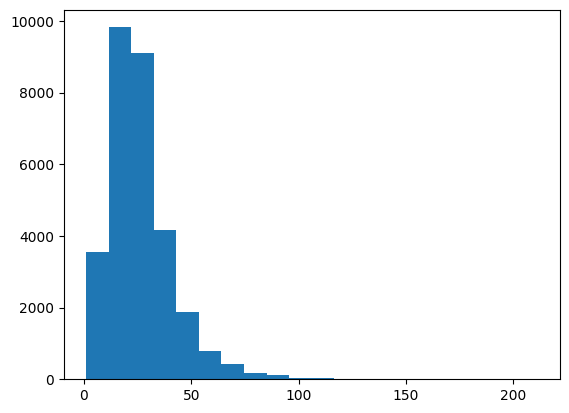

In [226]:
## What the distribution looks like
import matplotlib.pyplot as plt

plt.hist(sent_len, bins=20)

In [227]:
## How long the sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

55

In [228]:
## Maximum setence length
max(sent_len)

211

### Converting to numbers using textvectorization

In [229]:
import tensorflow as tf

## How many words are in our vocab (we have taken from the paper)
max_tokens = 68000
vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                               output_sequence_length=output_seq_len)

In [230]:
vectorizer.adapt(train_sentences)

In [231]:
vectorizer(train_sentences)

<tf.Tensor: shape=(30135, 55), dtype=int64, numpy=
array([[  23,   17,  422, ...,    0,    0,    0],
       [   8,  719, 2033, ...,    0,    0,    0],
       [ 729,  164,  466, ...,    0,    0,    0],
       ...,
       [  64,   10,   33, ...,    0,    0,    0],
       [  33,  135,   68, ...,    0,    0,    0],
       [2203,    8,  101, ...,    0,    0,    0]])>

In [232]:
## How many words are there in vocabulary
vocab_len = vectorizer.vocabulary_size()
vocab_len, vectorizer.get_vocabulary()[:5]

(24854, ['', '[UNK]', 'the', 'and', 'of'])

In [233]:
## Config of text vectorizer
vectorizer.get_config()

{'name': 'text_vectorization_3',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 24854}

### Creating Embedding layer

In [234]:
embedding = tf.keras.layers.Embedding(input_dim=vocab_len,
                                      output_dim=128,
                                      mask_zero=True)

In [235]:
embedding(vectorizer(train_sentences[0]))

<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[ 0.01588978,  0.02616799,  0.03563165, ..., -0.03417007,
        -0.0475444 ,  0.04570388],
       [-0.03078158, -0.04822425,  0.02457059, ...,  0.03159067,
         0.02387467, -0.01200352],
       [ 0.04507418,  0.00847728,  0.01256083, ..., -0.02260621,
        -0.03162519, -0.04309016],
       ...,
       [-0.01415559, -0.04085506, -0.04676279, ...,  0.00126008,
        -0.02458183,  0.01920512],
       [-0.01415559, -0.04085506, -0.04676279, ...,  0.00126008,
        -0.02458183,  0.01920512],
       [-0.01415559, -0.04085506, -0.04676279, ...,  0.00126008,
        -0.02458183,  0.01920512]], dtype=float32)>

### Creating Datasets (making sure that our data loads as fast as possible)

using tensorflow data API

> Resource: https://www.tensorflow.org/guide/data_performance

In [236]:
## Turn our data inot tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

In [237]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [238]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((30135, 5), array([1., 0., 0., 0., 0.]))

In [239]:
## Take the TensorSliceDataset's and turn them into "prefectched" dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [240]:
import tensorflow.keras.layers as layers
inputs = layers.Input(shape=(1, ), dtype='string')

x = vectorizer(inputs)

x = embedding(x)

x = layers.Conv1D(64,
                  kernel_size=3,
                  activation='relu')(x)

x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

In [241]:
model_1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 embedding_6 (Embedding)     (None, 55, 128)           3181312   
                                                                 
 conv1d_11 (Conv1D)          (None, 53, 64)            24640     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dense_2 (Dense)             (None, 5)                 325

In [242]:
model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [243]:
len(train_dataset)

942

In [244]:
len(train_dataset)*0.1

94.2

In [245]:
%%time
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=3,
                        validation_data=val_dataset,
                        validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
94/94 [==============================] - 13s 123ms/step - loss: 1.4543 - accuracy: 0.3590 - val_loss: 1.3926 - val_accuracy: 0.3752
Epoch 2/3
94/94 [==============================] - 6s 61ms/step - loss: 1.1918 - accuracy: 0.5479 - val_loss: 0.9826 - val_accuracy: 0.6224
Epoch 3/3
94/94 [==============================] - 5s 51ms/step - loss: 0.9156 - accuracy: 0.6469 - val_loss: 0.8293 - val_accuracy: 0.6753
CPU times: user 20.8 s, sys: 993 ms, total: 21.8 s
Wall time: 41.6 s


In [246]:
## Evaluating on validation dataset
model_1.evaluate(val_dataset)

5627/5627 [==============================] - 18s 3ms/step - loss: 0.8271 - accuracy: 0.6795


[0.8271488547325134, 0.6794601082801819]

In [247]:
## Predicting (our model predicts prediction probabilities for each class)
model_1_preds_probs = model_1.predict(test_dataset)
model_1_preds_probs, model_1_preds_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[0.3388078 , 0.33803347, 0.10563304, 0.15657045, 0.06095521],
        [0.39713043, 0.39160362, 0.03659926, 0.1409453 , 0.0337215 ],
        [0.44511175, 0.32382566, 0.03906475, 0.18280146, 0.00919642],
        ...,
        [0.00324204, 0.01613163, 0.08958987, 0.00429632, 0.88674015],
        [0.05867592, 0.11724703, 0.4279874 , 0.05263025, 0.34345943],
        [0.3023974 , 0.21888362, 0.2479662 , 0.11575899, 0.11499378]],
       dtype=float32),
 (30212, 5))

In [248]:
# model_1_preds = [item.argmax() for item in model_1_preds_probs]
model_1_preds = tf.argmax(model_1_preds_probs, axis=1)
model_1_preds[: 10].numpy()

array([0, 0, 0, 2, 2, 2, 2, 2, 4, 2])

In [249]:
## Calculating results
model_1_results = calculate_results(test_labels_encoded, model_1_preds)
model_1_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 68.36687408976566,
 'precision': 0.6384854061553551,
 'recall': 0.6836687408976566,
 'fscore': 0.653783625777519}

In [250]:
model_0_results

{'Accuracy': 67.79771161964008,
 'precision': 0.6775043255859432,
 'recall': 0.6779771161964008,
 'fscore': 0.6371863234667444}

### 2. TensorFlow-Hub pretrained Feature_Extractor

model taken from here: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

In [251]:
import tensorflow_hub as hub
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
pretrained_embedding = hub.KerasLayer(model_url, trainable=False, name="loaded_embedding")

In [252]:
import random
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(pretrained_embedding([random_sentence]).shape)

our sample of @ was chosen to detect an increase from @ % ( baseline ) to @ % ( app intervention ) in the proportion of patients expressing interest in discussing a larc method during their clinic visit with @ % power and two-sided = @ .
(1, 512)


In [253]:
inputs = layers.Input([], dtype='string')

x = pretrained_embedding(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

In [254]:
model_2.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None,)]                 0         
                                                                 
 loaded_embedding (KerasLay  (None, 512)               256797824 
 er)                                                             
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [255]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [256]:
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=3,
                        validation_data=val_dataset,
                        validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
94/94 [==============================] - 14s 124ms/step - loss: 1.2555 - accuracy: 0.5126 - val_loss: 1.0326 - val_accuracy: 0.5990
Epoch 2/3
94/94 [==============================] - 6s 65ms/step - loss: 0.9260 - accuracy: 0.6333 - val_loss: 0.8848 - val_accuracy: 0.6613
Epoch 3/3
94/94 [==============================] - 7s 74ms/step - loss: 0.8702 - accuracy: 0.6676 - val_loss: 0.8447 - val_accuracy: 0.6755


In [257]:
model_2_preds_probs = model_2.predict(val_dataset)
model_2_preds_probs

5627/5627 [==============================] - 58s 10ms/step


array([[0.40804377, 0.3002835 , 0.02809005, 0.2546729 , 0.00890972],
       [0.00224919, 0.00192909, 0.85673267, 0.00105085, 0.13803823],
       [0.13043186, 0.1847525 , 0.5076885 , 0.11033616, 0.06679088],
       ...,
       [0.19130035, 0.35674945, 0.12320242, 0.18862377, 0.140124  ],
       [0.10934481, 0.35210058, 0.01707852, 0.08234669, 0.43912938],
       [0.15570445, 0.07414417, 0.51551956, 0.20318702, 0.05144482]],
      dtype=float32)

In [258]:
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 2, 2, 2, 2])>

In [259]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'Accuracy': 67.53221506331927,
 'precision': 0.672506916819201,
 'recall': 0.6753221506331927,
 'fscore': 0.6674899938654476}

In [260]:
model_1_results

{'Accuracy': 68.36687408976566,
 'precision': 0.6384854061553551,
 'recall': 0.6836687408976566,
 'fscore': 0.653783625777519}

### Model_3. Conv1D with Charecter embedding

>Previously we created token-level embedding but we need to do similar steps for character-level embedding.


#### Creating Character level Tokenizer

In [261]:
train_sentences[:3]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .']

In [262]:
" ".join(list(train_sentences[0]))

't h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   a d h f   )   .'

In [263]:
## Make function to split sentences into characters

def sent_char(data_list):
  return " ".join(list(data_list))

In [264]:
train_chars = [sent_char(item)for item in train_sentences]
val_chars = [sent_char(item)for item in val_sentences]
test_chars = [sent_char(item)for item in test_sentences]

In [265]:
test_chars[1]

'i t   i s   n o t   c l e a r   w h e t h e r   t h e s e   p a t i e n t s   w o u l d   b e n e f i t   f r o m   a n t i f u n g a l   t r e a t m e n t   .'

In [266]:
## Average character length

char_len = [len(item) for item in train_sentences]
avg_char_len = np.mean(char_len)

In [267]:
avg_char_len

148.45996349759415

(array([1.263e+03, 5.400e+03, 7.937e+03, 6.822e+03, 4.258e+03, 2.292e+03,
        1.071e+03, 5.070e+02, 2.800e+02, 1.350e+02, 7.000e+01, 4.300e+01,
        2.500e+01, 1.000e+01, 6.000e+00, 7.000e+00, 6.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00]),
 array([  2.  ,  45.85,  89.7 , 133.55, 177.4 , 221.25, 265.1 , 308.95,
        352.8 , 396.65, 440.5 , 484.35, 528.2 , 572.05, 615.9 , 659.75,
        703.6 , 747.45, 791.3 , 835.15, 879.  ]),
 <BarContainer object of 20 artists>)

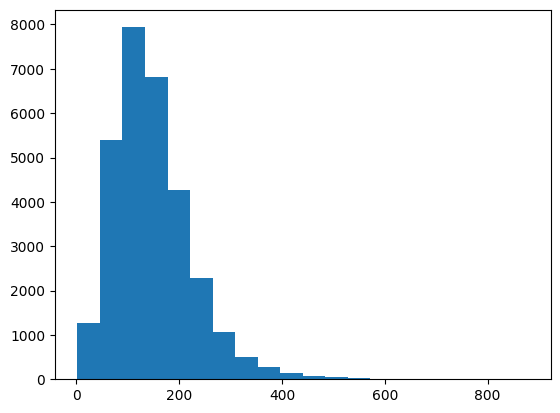

In [268]:
## Check the distribusion of the chars length

plt.hist(char_len, bins=20)

In [269]:
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

288

In [270]:
## Get the keyboard characters
import string
alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [271]:
## Create char-level token vectorizer instance
num_char_tokens = len(alphabets) + 2 ## Adding 2 because, the 'alphabets' does not contains space and voo ([UNK])

char_vectorizer = layers.TextVectorization(max_tokens=num_char_tokens,
                                           output_sequence_length = output_seq_char_len)

In [272]:
## Adapt char_vectorizer to training characters

char_vectorizer.adapt(train_chars)

In [273]:
## Getting char_vectorizer vocab stats

char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [274]:
random_chars = random.choice(train_chars)
char_vectorizer([random_chars])

<tf.Tensor: shape=(1, 288), dtype=int64, numpy=
array([[20,  2,  2, 21,  5, 12, 16,  5,  3,  2, 10,  5,  9,  9,  7, 11,
         4,  5,  3,  4,  7,  6,  9,  5, 15,  7,  6, 18, 11,  7, 15,  7,
         8, 22,  4, 10,  4,  3, 19,  3,  7, 24,  4, 11,  4,  3, 19,  3,
         4, 15,  2,  3,  7,  8,  2, 12,  5, 14,  9,  2,  3,  3,  8,  5,
         6, 10,  7, 21,  2,  8,  5, 12, 12,  9, 16,  8, 21,  4, 21,  5,
        12,  7,  9,  4,  6,  7, 12, 10,  2,  8, 20,  7, 15,  2,  6, 20,
         4,  3, 13,  2,  5,  8, 12, 19,  9,  3,  5, 18,  2, 22,  8,  2,
         5,  9,  3, 11,  5,  6, 11,  2,  8,  8,  2, 11,  2,  4, 21,  4,
         6, 18,  5, 10, 27, 16, 21,  5,  6,  3, 11, 13,  2, 15,  7,  3,
        13,  2,  8,  5, 14, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

#### Creating the model

In [275]:
char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                           output_dim=25,
                                           mask_zero=True)

In [276]:
char_embedding(char_vectorizer(random_chars))

<tf.Tensor: shape=(288, 25), dtype=float32, numpy=
array([[-0.03046143, -0.03595525,  0.01728438, ...,  0.00348015,
         0.00202112,  0.02367083],
       [ 0.04809405,  0.00689648,  0.01403185, ...,  0.01553469,
        -0.03040365,  0.03012807],
       [ 0.04809405,  0.00689648,  0.01403185, ...,  0.01553469,
        -0.03040365,  0.03012807],
       ...,
       [-0.01914923, -0.04093257, -0.02251852, ..., -0.04801115,
        -0.04934613, -0.02004683],
       [-0.01914923, -0.04093257, -0.02251852, ..., -0.04801115,
        -0.04934613, -0.02004683],
       [-0.01914923, -0.04093257, -0.02251852, ..., -0.04801115,
        -0.04934613, -0.02004683]], dtype=float32)>

In [277]:
np.array(train_chars).shape

(30135,)

In [293]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))

In [294]:
train_char_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [295]:
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [296]:
test_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [297]:
inputs = layers.Input(shape=(1, ), dtype='string')

x = char_vectorizer(inputs)

x = char_embedding(x)

x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)

x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(len(class_names), activation='softmax', name="ouput_layer")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [298]:
model_3.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 288)               0         
 Vectorization)                                                  
                                                                 
 embedding_7 (Embedding)     (None, 288, 25)           700       
                                                                 
 conv1d_14 (Conv1D)          (None, 288, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 ouput_layer (Dense)         (None, 5)                 325

In [299]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [300]:
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch=int(0.1 * len(train_char_dataset)),
                        epochs=3,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
94/94 [==============================] - 3s 24ms/step - loss: 1.4811 - accuracy: 0.3620 - val_loss: 1.4450 - val_accuracy: 0.3881
Epoch 2/3
94/94 [==============================] - 3s 33ms/step - loss: 1.4061 - accuracy: 0.4538 - val_loss: 1.3670 - val_accuracy: 0.4839
Epoch 3/3
94/94 [==============================] - 3s 29ms/step - loss: 1.3335 - accuracy: 0.4747 - val_loss: 1.2666 - val_accuracy: 0.4977


In [301]:
model_3_evalate = model_3.evaluate(val_char_dataset)
model_3_evalate

5627/5627 [==============================] - 22s 4ms/step - loss: 1.2631 - accuracy: 0.4997


[1.263120174407959, 0.49965009093284607]

In [302]:
model_3_preds_probs = model_3.predict(val_chars)
model_3_preds_probs

5627/5627 [==============================] - 18s 3ms/step


array([[0.13023551, 0.28519163, 0.21449721, 0.09410955, 0.27596614],
       [0.07051591, 0.05259182, 0.78817046, 0.0354827 , 0.05323911],
       [0.13161275, 0.1561033 , 0.48155388, 0.06906497, 0.16166516],
       ...,
       [0.1671665 , 0.2636702 , 0.18016808, 0.09142799, 0.2975672 ],
       [0.14112522, 0.16239412, 0.4001008 , 0.07352125, 0.22285862],
       [0.14940926, 0.14565921, 0.38424066, 0.08322332, 0.23746757]],
      dtype=float32)

In [303]:
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 2, 2, 2, 2])>

In [304]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 49.96500777604977,
 'precision': 0.47476123496156514,
 'recall': 0.4996500777604977,
 'fscore': 0.4091341766514261}

### Model_4: Pretrained token embedding(same as 2) + Charecter embedding (same as 3)